# DEMO 4

Cross Validation with Decision Trees


In [1]:
import sys
import os

# Manually set the path relative to the py file's location that you want to import
func_lib_path = os.path.abspath(os.path.join(os.getcwd(), '../'))# Add the path to sys.path
sys.path.append(func_lib_path)

# Now you can import func_lib
import func_lib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
historical_prices = func_lib.createHistPrices()
list_of_momentums = [1, 5, 15, 20]
total_returns     = func_lib.computingReturns(historical_prices, list_of_momentums)
total_returns.dropna(inplace=True)

[*********************100%***********************]  501 of 501 completed

1 Failed download:
['SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2000-01-01 -> 2024-05-01) (Yahoo error = "Data doesn\'t exist for startDate = 946702800, endDate = 1714536000")')


In [3]:
total_returns.head()

F_1_d_returns  1_d_returns  5_d_returns  \
Ticker Date                                                                 
A      2000-02-01 00:00:00+00:00       0.077465     0.072710     0.048938   
       2000-02-02 00:00:00+00:00       0.016340     0.077465     0.119854   
       2000-02-03 00:00:00+00:00      -0.019293     0.016340     0.136073   
       2000-02-04 00:00:00+00:00       0.042623    -0.019293     0.120294   
       2000-02-07 00:00:00+00:00      -0.006289     0.042623     0.201133   

                                  15_d_returns  20_d_returns  
Ticker Date                                                   
A      2000-02-01 00:00:00+00:00      0.029918     -0.013889  
       2000-02-02 00:00:00+00:00      0.125000      0.150376  
       2000-02-03 00:00:00+00:00      0.166980      0.246493  
       2000-02-04 00:00:00+00:00      0.127541      0.270833  
       2000-02-07 00:00:00+00:00      0.162706      0.223077

In [4]:
# Converting the 'F_1_d_returns' to binary based on whether the value is positive or not
total_returns['F_1_d_returns_Ind'] = total_returns['F_1_d_returns'].apply(lambda x: 1 if x > 0 else 0)
total_returns.head()

F_1_d_returns  1_d_returns  5_d_returns  \
Ticker Date                                                                 
A      2000-02-01 00:00:00+00:00       0.077465     0.072710     0.048938   
       2000-02-02 00:00:00+00:00       0.016340     0.077465     0.119854   
       2000-02-03 00:00:00+00:00      -0.019293     0.016340     0.136073   
       2000-02-04 00:00:00+00:00       0.042623    -0.019293     0.120294   
       2000-02-07 00:00:00+00:00      -0.006289     0.042623     0.201133   

                                  15_d_returns  20_d_returns  \
Ticker Date                                                    
A      2000-02-01 00:00:00+00:00      0.029918     -0.013889   
       2000-02-02 00:00:00+00:00      0.125000      0.150376   
       2000-02-03 00:00:00+00:00      0.166980      0.246493   
       2000-02-04 00:00:00+00:00      0.127541      0.270833   
       2000-02-07 00:00:00+00:00      0.162706      0.223077   

                                  F_1_d_returns_Ind  
Ticker Date                                          
A      2000-02-01 00:00:00+00:00                  1  
       2000-02-02 00:00:00+00:00                  1  
       2000-02-03 00:00:00+00:00                  0  
       2000-02-04 00:00:00+00:00                  1  
       2000-02-07 00:00:00+00:00                  0

In [5]:
# Determine the split index for 70% of the dates
unique_dates = total_returns.index.get_level_values('Date').unique()
split_date = unique_dates[int(0.7 * len(unique_dates))]
split_date

Timestamp('2017-01-20 00:00:00+0000', tz='UTC')

In [6]:
# Create the training set: all data before the split date
train_data = total_returns.loc[total_returns.index.get_level_values('Date') < split_date]

# Create the testing set: all data from the split date onwards
test_data = total_returns.loc[total_returns.index.get_level_values('Date') >= split_date]

In [7]:
total_returns  = test_data['F_1_d_returns']

In [8]:
features = ['1_d_returns', '5_d_returns', '15_d_returns', '20_d_returns']
target   = ['F_1_d_returns_Ind']

# Split the data into training and testing sets
X_train = train_data[features]
X_test  = test_data[features]
y_train = train_data[target]
y_test  = test_data[target]

In [9]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

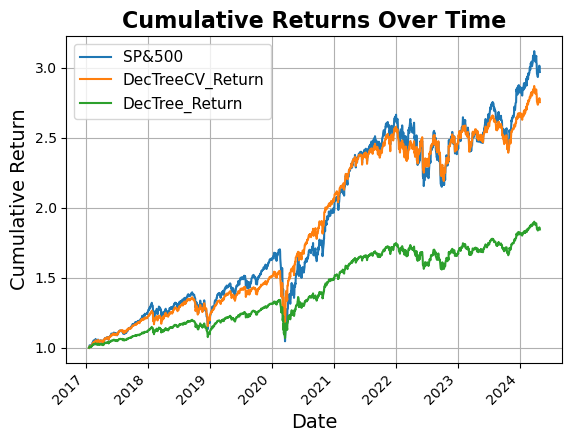

The CAGR is: 8.74%
Sharpe Ratio of Strategy: 0.89


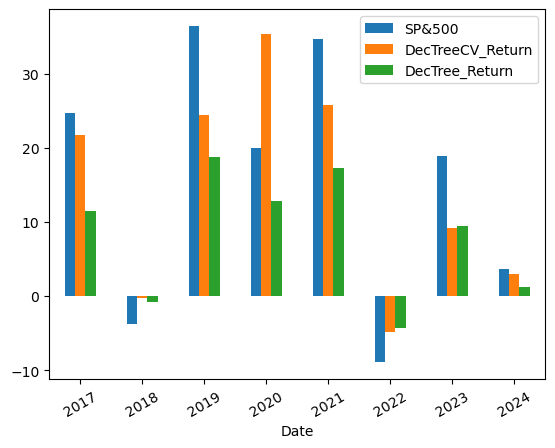

In [18]:
# Initialize and train Decision Tree classifier
model = DecisionTreeClassifier()
model.fit(X_train_scaled, y_train)
model_name = 'DecTree'
# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_df = pd.DataFrame(y_pred, index= X_test_scaled.index)

y_pred_df.rename(columns={0:model_name}, inplace=True)

y_test_df = pd.DataFrame(y_test)
y_test_and_pred = pd.merge(y_pred_df, total_returns, left_index=True, right_index=True)
# Define trading strategy based on Logit
def trading_strategy(y_pred):
    if y_pred > 0 :
        return  1 # Go long
    else:
        return  0  
cum_returns, calendar_returns = func_lib.compute_BM_Perf(y_test_and_pred)
cum_returns, calendar_returns = func_lib.compute_strat_perf(y_test_and_pred, cum_returns, calendar_returns, trading_strategy, model_name)

In [11]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree classifier
dt = DecisionTreeClassifier()

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time= 1.6min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time= 1.5min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time= 1.2min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time= 1.2min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time= 1.3min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time= 1.1min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time= 1.3min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time= 1.3min
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2; total time= 1.3min
[CV] END criterion=gini, m

In [12]:
# Get the best model
best_model = grid_search.best_estimator_

[CV] END criterion=gini, max_depth=15, min_samples_leaf=2, min_samples_split=10; total time=  28.4s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=2, min_samples_split=10; total time=  28.7s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=2, min_samples_split=10; total time=  27.8s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2; total time=  28.3s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2; total time=  28.1s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=5; total time=  27.6s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=5; total time=  29.1s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=5; total time=  28.6s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=10; total time=  27.6s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=10; total time=  27.7s
[CV] 

In [13]:
model_name = 'DecTreeCV'
# Make predictions
y_pred = best_model.predict(X_test_scaled)
y_pred_df = pd.DataFrame(y_pred, index= X_test_scaled.index)

y_pred_df.rename(columns={0:model_name}, inplace=True)

y_test_df = pd.DataFrame(y_test)

In [14]:
y_test_and_pred = pd.merge(y_pred_df, total_returns, left_index=True, right_index=True)
#y_test_and_pred = pd.merge(y_test_and_pred, total_returns, left_index=True, right_index=True)

In [15]:

# Define trading strategy based on RSI
def trading_strategy(y_pred):
    if y_pred >0:
        return  1 # Go long
    else:
        return 0
        

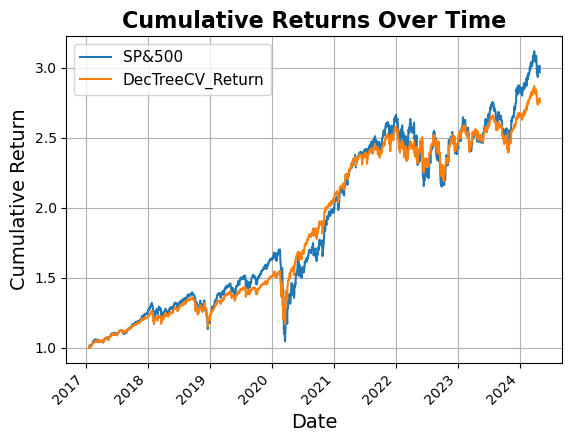

The CAGR is: 14.88%
Sharpe Ratio of Strategy: 0.99


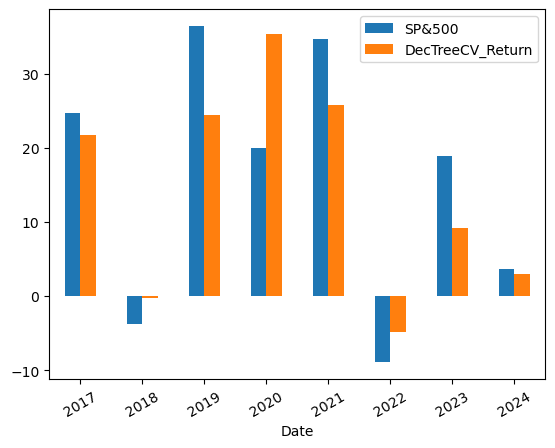

In [17]:
cum_returns, calendar_returns = func_lib.compute_strat_perf(y_test_and_pred, cum_returns, calendar_returns, trading_strategy, model_name)